***Autorki***: Anna Gnoińska - ania.gnoinska@gmail.com
Julia Ignacyk - juliaignacyk@gmail.com


# Funkcje pomocnicze

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from keras import models
from keras import layers
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import neural_network
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline


In [21]:
## [deskew]
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]


In [22]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

In [23]:
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

In [24]:
def SVM_best_params(imData, train_labels):
  parameters = {'kernel':('linear','rbf'), 'C':[1,10], 'gamma':('scale', 'auto')}

  svc = svm.SVC()
  clf = GridSearchCV(svc, parameters, cv=5, verbose=3)
  clf.fit(imData[:6000], train_labels[:6000])
  print("\nBest score: ")
  print(clf.best_score_)
  print("\nBest params: ")
  print(clf.best_params_)

  return clf.best_params_

In [25]:
def SVM_classifier(imData, train_labels):
  
  model = svm.SVC(**SVM_best_params(imData,train_labels))
  model = model.fit(imData[0:600,:],train_labels[0:600])

  pred_labels = model.predict(imData[600:1000,:])
  mask = pred_labels==train_labels[600:1000]
  correct = np.count_nonzero(mask)
  print("\nAccuracy:")
  print(correct*100.0/pred_labels.size)

  cm = confusion_matrix(train_labels[600:1000], pred_labels)
  print("\nConfusion matrix:")
  fig = plt.figure(figsize = (10,10))
  sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
  plt.show()
  
  print("\nClassification report:")
  print(classification_report(train_labels[600:1000], pred_labels))

In [26]:
def RFC_best_params(imData, train_labels):
  params = {'max_features': [1,15,30],
          'max_depth': [5,10,25], 
          'criterion': ["entropy","gini"]}
  model = RandomForestClassifier()

  grid=GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=4)
  grid.fit(imData[:6000], train_labels[:6000])

  print("Best score: ")
  print(grid.best_score_)
  print("\nBest params: ")
  print(grid.best_params_)
  return grid.best_params_

In [27]:
def RFC_classifier(imData,train_labels):
  rfc =  RandomForestClassifier(**RFC_best_params(imData,train_labels))
  rfc = rfc.fit(imData[0:600,:],train_labels[0:600])

  pred_labels = rfc.predict(imData[600:1000,:])

  mask = pred_labels==train_labels[600:1000]
  correct = np.count_nonzero(mask)
  print("\nAccuracy:")
  print(correct*100.0/pred_labels.size)

  cm = confusion_matrix(train_labels[600:1000], pred_labels)
  
  print("\nConfusion matrix:")
  fig = plt.figure(figsize = (10,10))
  sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
  plt.show()


  print("\nClassification report:")
  print(classification_report(train_labels[600:1000], pred_labels))

In [89]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras import models
from keras import layers
from keras.utils import to_categorical

def create_model():
  network_deskewed = models.Sequential()
  network_deskewed.add(layers.Dense(512, activation='relu'))
  network_deskewed.add(layers.Dense(10, activation='softmax'))
  network_deskewed.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return network_deskewed

def NN_best_params(imData, encoded_train_labels, network):
  epochs = [8, 10, 15]
  param_grid = dict(epochs=epochs)
  grid = GridSearchCV(network, param_grid, cv=5, n_jobs=-1)


  grid.fit(imData2[:7500], encoded_train_labels[:7500], batch_size=128)

  print("Best score: %0.4f" % clf_grid.best_score_)
  print("\nBest params: ")
  print(grid.best_params_)  



# Projekt 2

### Wczytanie danych

In [35]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

### Klasyfikatory bez wyrównania 

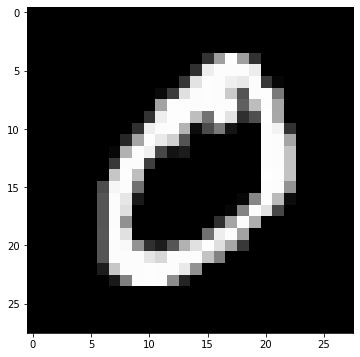

0


In [36]:
im_list = [train_images[i] for i in range(0,train_images.shape[0])] + [test_images[i] for i in range(0,test_images.shape[0])]

# Przed wyrównaniem:
showOpencvImage(train_images[1])
print(train_labels[1])

In [37]:
hogdata = [openCVHOG(im) for im in im_list]
imData = np.float32(hogdata).reshape(-1,81)
print(imData.shape)

(70000, 81)


**SVM**

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.945, total=   0.6s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.956, total=   0.6s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.957, total=   0.6s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.943, total=   0.6s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.948, total=   0.6s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.951, total=   1.2s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.962, total=   1.3s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.966, total=   1.3s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.950, total=   1.3s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   43.2s finished


Best score: 
0.9594999999999999

Best params: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Accuracy:
92.0

Confusion matrix:


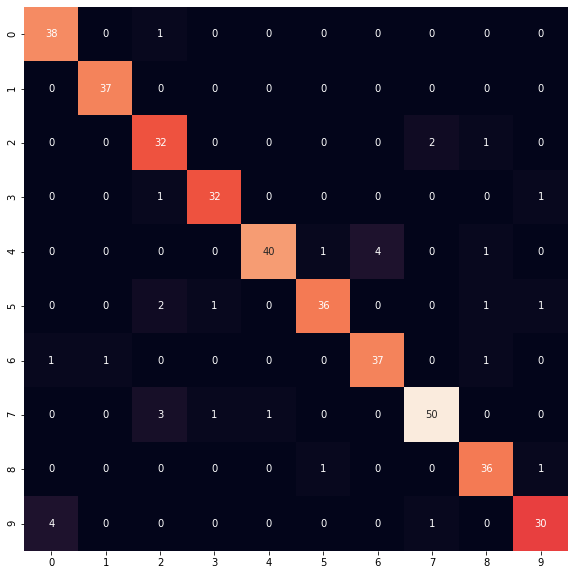


Classification report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        39
           1       0.97      1.00      0.99        37
           2       0.82      0.91      0.86        35
           3       0.94      0.94      0.94        34
           4       0.98      0.87      0.92        46
           5       0.95      0.88      0.91        41
           6       0.90      0.93      0.91        40
           7       0.94      0.91      0.93        55
           8       0.90      0.95      0.92        38
           9       0.91      0.86      0.88        35

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [ ]:
SVM_classifier(imData,train_labels)

**RFC**

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.870, total=   1.0s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.872, total=   1.0s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.853, total=   1.0s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.881, total=   1.0s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................
[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.858, total=   1.0s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.886, total=  10.3s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.897, total=  10.4s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.896, total=  10.3s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.875, total=  10.2s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.868, total=  10.3s
[C

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 13.1min finished


Best score: 
0.9428333333333333

Best params: 
{'criterion': 'gini', 'max_depth': 25, 'max_features': 15}

Accuracy:
87.0

Confusion matrix:


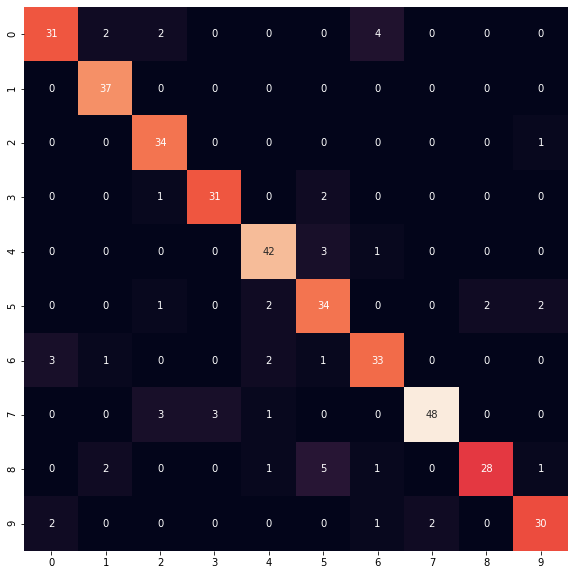


Classification report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.83        39
           1       0.88      1.00      0.94        37
           2       0.83      0.97      0.89        35
           3       0.91      0.91      0.91        34
           4       0.88      0.91      0.89        46
           5       0.76      0.83      0.79        41
           6       0.82      0.82      0.82        40
           7       0.96      0.87      0.91        55
           8       0.93      0.74      0.82        38
           9       0.88      0.86      0.87        35

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [ ]:
RFC_classifier(imData,train_labels)

**Sieć**

In [91]:
network = create_model
NN_best_params(imData2, encoded_train_labels, KerasClassifier(network))

Epoch 1/10
59/59 [==============================] - 1s 2ms/step - loss: 1.4653 - accuracy: 0.6662
Epoch 2/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4373 - accuracy: 0.9052
Epoch 3/10
59/59 [==============================] - 0s 2ms/step - loss: 0.2643 - accuracy: 0.9290
Epoch 4/10
59/59 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.9455
Epoch 5/10
59/59 [==============================] - 0s 3ms/step - loss: 0.1695 - accuracy: 0.9552
Epoch 6/10
59/59 [==============================] - 0s 2ms/step - loss: 0.1571 - accuracy: 0.9536
Epoch 7/10
59/59 [==============================] - 0s 2ms/step - loss: 0.1357 - accuracy: 0.9579
Epoch 8/10
59/59 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9615
Epoch 9/10
59/59 [==============================] - 0s 2ms/step - loss: 0.1236 - accuracy: 0.9650
Epoch 10/10
59/59 [==============================] - 0s 2ms/step - loss: 0.1137 - accuracy: 0.9663
Best score: 0.8991


Epoch 1/10
75/75 [==============================] - 0s 2ms/step - loss: 1.4135 - accuracy: 0.7172
Epoch 2/10
75/75 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.9164
Epoch 3/10
75/75 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.9358
Epoch 4/10
75/75 [==============================] - 0s 2ms/step - loss: 0.1776 - accuracy: 0.9488
Epoch 5/10
75/75 [==============================] - 0s 2ms/step - loss: 0.1654 - accuracy: 0.9512
Epoch 6/10
75/75 [==============================] - 0s 2ms/step - loss: 0.1388 - accuracy: 0.9602
Epoch 7/10
75/75 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.9612
Epoch 8/10
75/75 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9637
Epoch 9/10
75/75 [==============================] - 0s 2ms/step - loss: 0.1171 - accuracy: 0.9626
Epoch 10/10
79/79 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.8620

Accuracy: 0.861999

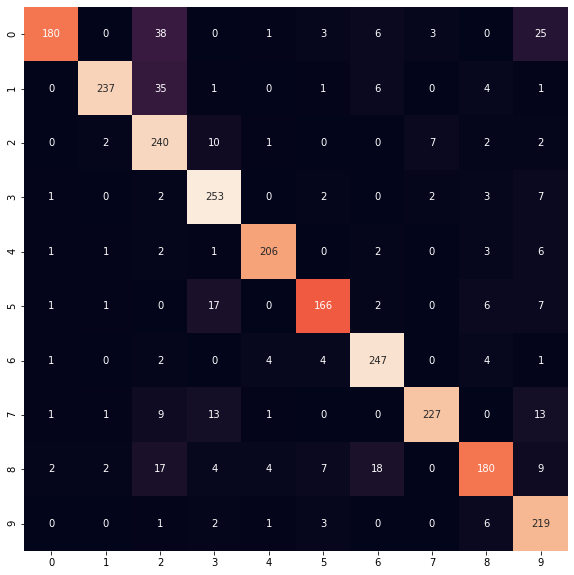


Classification report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       256
           1       0.97      0.83      0.90       285
           2       0.69      0.91      0.79       264
           3       0.84      0.94      0.89       270
           4       0.94      0.93      0.94       222
           5       0.89      0.83      0.86       200
           6       0.88      0.94      0.91       263
           7       0.95      0.86      0.90       265
           8       0.87      0.74      0.80       243
           9       0.76      0.94      0.84       232

    accuracy                           0.86      2500
   macro avg       0.88      0.86      0.86      2500
weighted avg       0.88      0.86      0.86      2500



In [92]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(81,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

encoded_train_labels = to_categorical(train_labels)

network.fit(imData2[:7500], encoded_train_labels[:7500], epochs=10, batch_size=100)

test_loss, test_acc = network.evaluate(imData[7500:10000], encoded_train_labels[7500:10000])
print('\nAccuracy:', test_acc)
pred_probabilities = network.predict(imData[7500:10000])
# print(pred_probabilities[0:1])
pred_labels = np.argmax(pred_probabilities,-1)

cm = confusion_matrix(train_labels[7500:10000], pred_labels)
print("\nConfusion matrix:")
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()

print("\nClassification report:")
print(classification_report(train_labels[7500:10000], pred_labels))

### Klasyfikatory z wyrównaniem 

70000


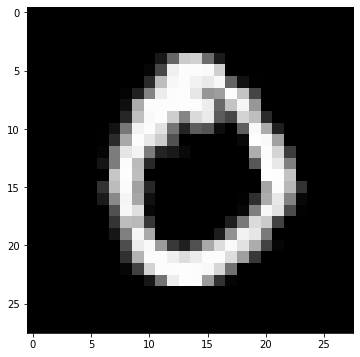

0


In [93]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_deskewed = [deskew(im) for im in im_list[0:train_images.shape[0]]]
test_deskewed = [deskew(im) for im in im_list[train_images.shape[0]:]]

train_deskewed = np.asarray(train_deskewed)
test_deskewed = np.asarray(test_deskewed)

im_list2 = [train_deskewed[i] for i in range(0,train_deskewed.shape[0])] + [test_deskewed[i] for i in range(0,test_deskewed.shape[0])]
print(len(im_list))

# Po wyrównaniu: 
showOpencvImage(train_deskewed[1])
print(train_labels[1])

In [94]:
hogdata2 = [openCVHOG(im) for im in im_list2]
imData2 = np.float32(hogdata2).reshape(-1,81)
print(imData2.shape)

(70000, 81)


 **SVM**

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.967, total=   0.5s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.968, total=   0.5s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.969, total=   0.5s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.956, total=   0.5s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.964, total=   0.5s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.967, total=   1.0s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.973, total=   1.0s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.969, total=   1.0s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.959, total=   1.0s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   35.1s finished



Best score: 
0.9706666666666667

Best params: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Accuracy:
93.75

Confusion matrix:


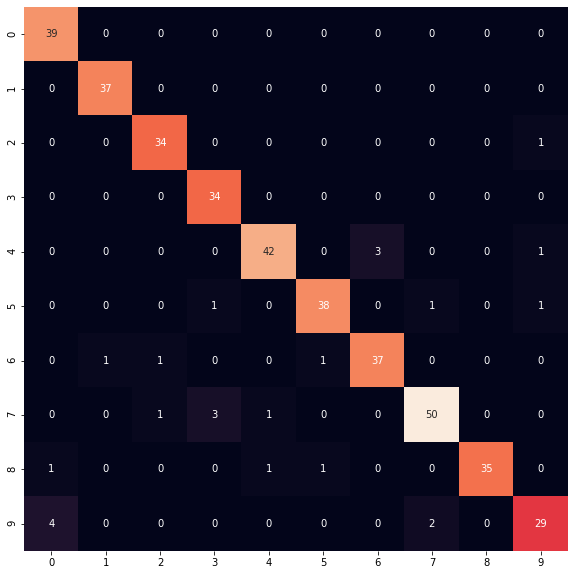


Classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        39
           1       0.97      1.00      0.99        37
           2       0.94      0.97      0.96        35
           3       0.89      1.00      0.94        34
           4       0.95      0.91      0.93        46
           5       0.95      0.93      0.94        41
           6       0.93      0.93      0.93        40
           7       0.94      0.91      0.93        55
           8       1.00      0.92      0.96        38
           9       0.91      0.83      0.87        35

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



In [ ]:
SVM_classifier(imData2,train_labels)

**RFC**

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.908, total=   1.1s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.920, total=   1.1s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.917, total=   1.1s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.899, total=   1.1s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................
[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.902, total=   1.1s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.932, total=  10.6s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.937, total=  10.6s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.918, total=  10.6s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.905, total=  10.6s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.899, total=  10.6s
[C

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 13.2min finished


Best score: 
0.9551666666666666

Best params: 
{'criterion': 'entropy', 'max_depth': 25, 'max_features': 15}

Accuracy:
93.25

Confusion matrix:


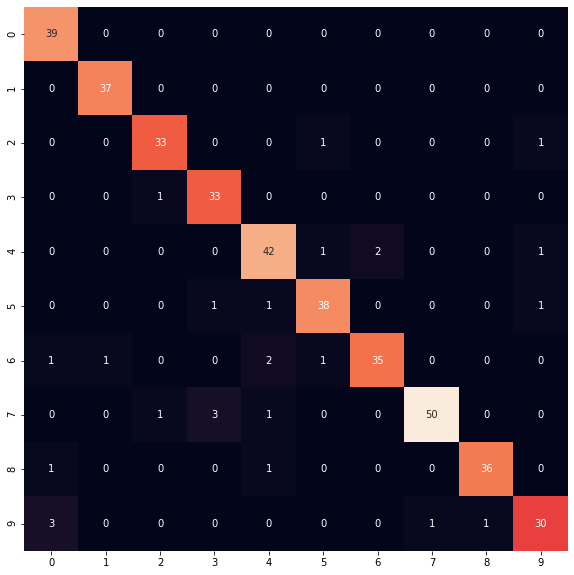


Classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        39
           1       0.97      1.00      0.99        37
           2       0.94      0.94      0.94        35
           3       0.89      0.97      0.93        34
           4       0.89      0.91      0.90        46
           5       0.93      0.93      0.93        41
           6       0.95      0.88      0.91        40
           7       0.98      0.91      0.94        55
           8       0.97      0.95      0.96        38
           9       0.91      0.86      0.88        35

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [ ]:
RFC_classifier(imData2,train_labels)

**Sieć**

In [95]:
network = create_model
NN_best_params(imData2, encoded_train_labels, KerasClassifier(network))

Epoch 1/15
59/59 [==============================] - 0s 2ms/step - loss: 1.4976 - accuracy: 0.6712
Epoch 2/15
59/59 [==============================] - 0s 2ms/step - loss: 0.4476 - accuracy: 0.9089
Epoch 3/15
59/59 [==============================] - 0s 2ms/step - loss: 0.2657 - accuracy: 0.9347
Epoch 4/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1970 - accuracy: 0.9473
Epoch 5/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9527
Epoch 6/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9552
Epoch 7/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1320 - accuracy: 0.9600
Epoch 8/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1372 - accuracy: 0.9598
Epoch 9/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9626
Epoch 10/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1119 - accuracy: 0.9647
Epoch 11/15
59/59 [

Epoch 1/15
59/59 [==============================] - 0s 2ms/step - loss: 1.4963 - accuracy: 0.6874
Epoch 2/15
59/59 [==============================] - 0s 2ms/step - loss: 0.4488 - accuracy: 0.9137
Epoch 3/15
59/59 [==============================] - 0s 2ms/step - loss: 0.2653 - accuracy: 0.9325
Epoch 4/15
59/59 [==============================] - 0s 3ms/step - loss: 0.2045 - accuracy: 0.9424
Epoch 5/15
59/59 [==============================] - 0s 3ms/step - loss: 0.1746 - accuracy: 0.9506
Epoch 6/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1553 - accuracy: 0.9536
Epoch 7/15
59/59 [==============================] - 0s 3ms/step - loss: 0.1536 - accuracy: 0.9551
Epoch 8/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1370 - accuracy: 0.9572
Epoch 9/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1225 - accuracy: 0.9615
Epoch 10/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9675
Epoch 11/15
59/59 [

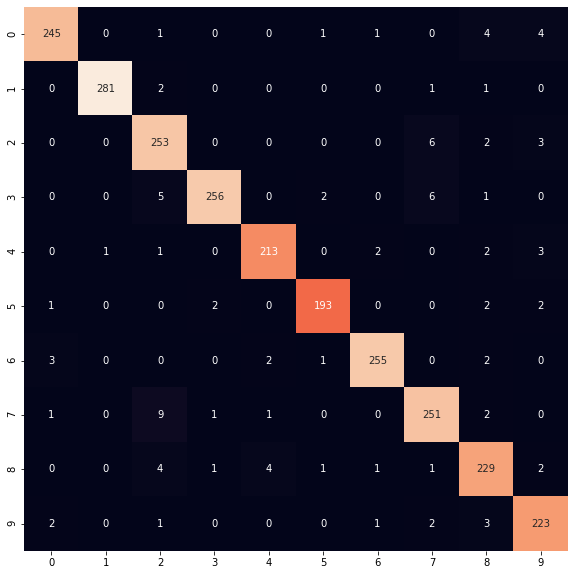


Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       256
           1       1.00      0.99      0.99       285
           2       0.92      0.96      0.94       264
           3       0.98      0.95      0.97       270
           4       0.97      0.96      0.96       222
           5       0.97      0.96      0.97       200
           6       0.98      0.97      0.98       263
           7       0.94      0.95      0.94       265
           8       0.92      0.94      0.93       243
           9       0.94      0.96      0.95       232

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [96]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(81,)))
network.add(layers.Dense(10, activation='softmax'))
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
encoded_train_labels = to_categorical(train_labels)

network.fit(imData2[:7500], encoded_train_labels[:7500], epochs=15, batch_size=128)

test_loss, test_acc = network.evaluate(imData2[7500:10000], encoded_train_labels[7500:10000])
print('\nAccuracy:', test_acc)
pred_probabilities = network.predict(imData2[7500:10000])
# print(pred_probabilities[0:1])
pred_labels = np.argmax(pred_probabilities,-1)

cm = confusion_matrix(train_labels[7500:10000], pred_labels)
print("\nConfusion matrix:")
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()

print("\nClassification report:")
print(classification_report(train_labels[7500:10000], pred_labels))



### Klasyfikatory dla surowych danych 

In [98]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_deskewed = [deskew(im) for im in im_list[0:train_images.shape[0]]]
test_deskewed = [deskew(im) for im in im_list[train_images.shape[0]:]]

train_deskewed = np.asarray(train_deskewed)
test_deskewed = np.asarray(test_deskewed)

im_list3 = [train_deskewed[i] for i in range(0,train_deskewed.shape[0])] + [test_deskewed[i] for i in range(0,test_deskewed.shape[0])]
im_list3_reshaped = [im_list3[im].reshape(-1) for im in range (0,len(im_list3))]

imData3 = np.float32(im_list3_reshaped).reshape(-1,784)
print(imData3.shape)

(70000, 784)


**SVM**

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.934, total=   5.7s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.946, total=   5.9s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.946, total=   5.9s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.944, total=   5.9s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.921, total=   5.7s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.953, total=  10.2s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.967, total=  10.6s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.969, total=  10.6s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.963, total=  10.7s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 13.8min finished



Best score: 
0.9671666666666667

Best params: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Accuracy:
92.25

Confusion matrix:


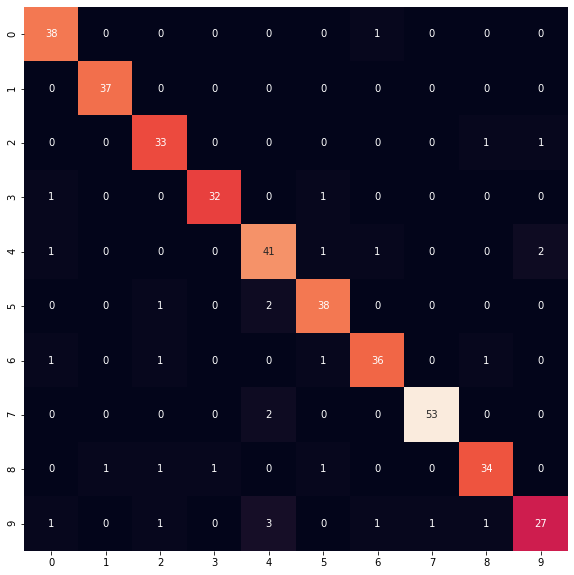


Classification report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        39
           1       0.97      1.00      0.99        37
           2       0.89      0.94      0.92        35
           3       0.97      0.94      0.96        34
           4       0.85      0.89      0.87        46
           5       0.90      0.93      0.92        41
           6       0.92      0.90      0.91        40
           7       0.98      0.96      0.97        55
           8       0.92      0.89      0.91        38
           9       0.90      0.77      0.83        35

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [ ]:
SVM_classifier(imData3,train_labels)

**RFC**

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.800, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.838, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.801, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.819, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................
[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.817, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.897, total=   1.9s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.907, total=   1.9s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.903, total=   1.9s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.884, total=   1.9s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.889, total=   1.9s
[C

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.3min finished


Best score: 
0.9508333333333333

Best params: 
{'criterion': 'gini', 'max_depth': 25, 'max_features': 30}

Accuracy:
89.5

Confusion matrix:


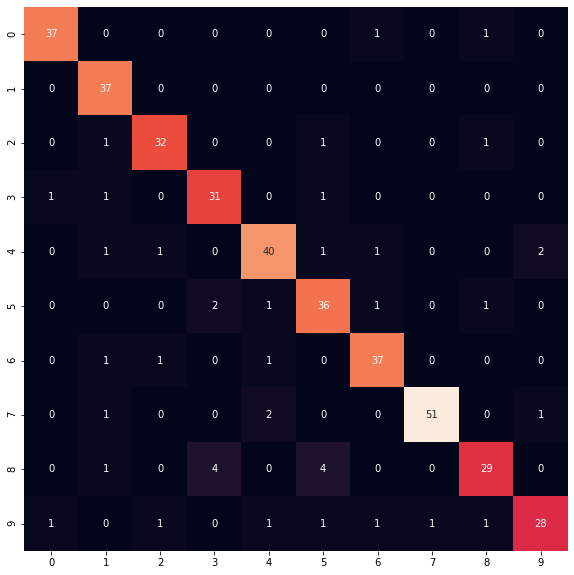


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.86      1.00      0.92        37
           2       0.91      0.91      0.91        35
           3       0.84      0.91      0.87        34
           4       0.89      0.87      0.88        46
           5       0.82      0.88      0.85        41
           6       0.90      0.93      0.91        40
           7       0.98      0.93      0.95        55
           8       0.88      0.76      0.82        38
           9       0.90      0.80      0.85        35

    accuracy                           0.90       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.90      0.89       400



In [ ]:
RFC_classifier(imData3,train_labels)

**Sieć**

In [99]:
network = create_model
NN_best_params(imData3, encoded_train_labels, KerasClassifier(network))

Epoch 1/15
59/59 [==============================] - 1s 3ms/step - loss: 1.4943 - accuracy: 0.6814
Epoch 2/15
59/59 [==============================] - 0s 3ms/step - loss: 0.4328 - accuracy: 0.9149
Epoch 3/15
59/59 [==============================] - 0s 2ms/step - loss: 0.2639 - accuracy: 0.9327
Epoch 4/15
59/59 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.9407
Epoch 5/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1776 - accuracy: 0.9492
Epoch 6/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1580 - accuracy: 0.9573
Epoch 7/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.9563
Epoch 8/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.9626
Epoch 9/15
59/59 [==============================] - 0s 3ms/step - loss: 0.1203 - accuracy: 0.9624
Epoch 10/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1256 - accuracy: 0.9602
Epoch 11/15
59/59 [

Epoch 1/15
59/59 [==============================] - 1s 3ms/step - loss: 54.6793 - accuracy: 0.6877
Epoch 2/15
59/59 [==============================] - 0s 3ms/step - loss: 4.0452 - accuracy: 0.9189
Epoch 3/15
59/59 [==============================] - 0s 3ms/step - loss: 1.9345 - accuracy: 0.9470
Epoch 4/15
59/59 [==============================] - 0s 3ms/step - loss: 1.2129 - accuracy: 0.9611
Epoch 5/15
59/59 [==============================] - 0s 3ms/step - loss: 0.9808 - accuracy: 0.9677
Epoch 6/15
59/59 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.9773
Epoch 7/15
59/59 [==============================] - 0s 3ms/step - loss: 0.4439 - accuracy: 0.9803
Epoch 8/15
59/59 [==============================] - 0s 3ms/step - loss: 0.4592 - accuracy: 0.9806
Epoch 9/15
59/59 [==============================] - 0s 3ms/step - loss: 0.4113 - accuracy: 0.9814
Epoch 10/15
59/59 [==============================] - 0s 3ms/step - loss: 0.4249 - accuracy: 0.9822
Epoch 11/15
59/59 

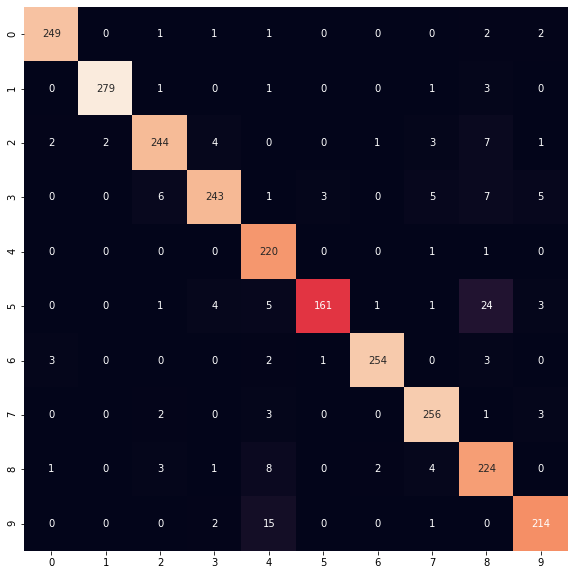

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       256
           1       0.99      0.98      0.99       285
           2       0.95      0.92      0.93       264
           3       0.95      0.90      0.93       270
           4       0.86      0.99      0.92       222
           5       0.98      0.81      0.88       200
           6       0.98      0.97      0.98       263
           7       0.94      0.97      0.95       265
           8       0.82      0.92      0.87       243
           9       0.94      0.92      0.93       232

    accuracy                           0.94      2500
   macro avg       0.94      0.93      0.94      2500
weighted avg       0.94      0.94      0.94      2500



In [100]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(784,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

encoded_train_labels = to_categorical(train_labels)
network.fit(imData3[:7500], encoded_train_labels[:7500], epochs=15, batch_size=128)

test_loss, test_acc = network.evaluate(imData3[7500:10000], encoded_train_labels[7500:10000])
print('test_acc:', test_acc)

pred_probabilities = network.predict(imData3[7500:10000])

pred_labels = np.argmax(pred_probabilities,-1)

cm = confusion_matrix(train_labels[7500:10000], pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()
print(classification_report(train_labels[7500:10000], pred_labels))

### Klasyfikatory dla zmieszanych danych 


In [101]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_deskewed = [deskew(im) for im in im_list[0:train_images.shape[0]]]
test_deskewed = [deskew(im) for im in im_list[train_images.shape[0]:]]

train_deskewed = np.asarray(train_deskewed)
test_deskewed = np.asarray(test_deskewed)

im_list4 = [train_deskewed[i] for i in range(0,train_deskewed.shape[0])] + [test_deskewed[i] for i in range(0,test_deskewed.shape[0])]

for i in im_list4:
    np.random.shuffle(i)

imData4 = np.float32(im_list4).reshape(-1,784)
print(imData4.shape)

(70000, 784)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.466, total=  39.5s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.5s remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.457, total=  38.0s
[CV] C=1, gamma=scale, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ..... C=1, gamma=scale, kernel=linear, score=0.431, total=  35.9s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.443, total=  38.9s
[CV] C=1, gamma=scale, kernel=linear .................................
[CV] ..... C=1, gamma=scale, kernel=linear, score=0.454, total=  37.7s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.615, total=  40.8s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.576, total=  40.8s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.572, total=  40.7s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] ........ C=1, gamma=scale, kernel=rbf, score=0.578, total=  40.2s
[CV] C=1, gamma=scale, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 31.7min finished



Best score: 
0.6083333333333333

Best params: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Accuracy:
42.0

Confusion matrix:


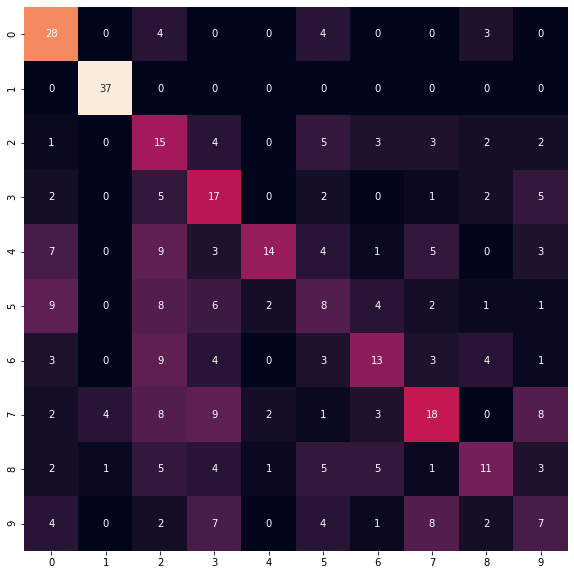


Classification report:
              precision    recall  f1-score   support

           0       0.48      0.72      0.58        39
           1       0.88      1.00      0.94        37
           2       0.23      0.43      0.30        35
           3       0.31      0.50      0.39        34
           4       0.74      0.30      0.43        46
           5       0.22      0.20      0.21        41
           6       0.43      0.33      0.37        40
           7       0.44      0.33      0.37        55
           8       0.44      0.29      0.35        38
           9       0.23      0.20      0.22        35

    accuracy                           0.42       400
   macro avg       0.44      0.43      0.41       400
weighted avg       0.45      0.42      0.41       400



In [ ]:
SVM_classifier(imData4,train_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.338, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.340, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.316, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.316, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=1 ..................
[CV]  criterion=entropy, max_depth=5, max_features=1, score=0.343, total=   0.4s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.417, total=   2.3s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.420, total=   2.2s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.394, total=   2.2s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.412, total=   2.2s
[CV] criterion=entropy, max_depth=5, max_features=15 .................
[CV]  criterion=entropy, max_depth=5, max_features=15, score=0.412, total=   2.3s
[C

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.5min finished


Best score: 
0.4923333333333334

Best params: 
{'criterion': 'gini', 'max_depth': 10, 'max_features': 30}

Accuracy:
37.5

Confusion matrix:


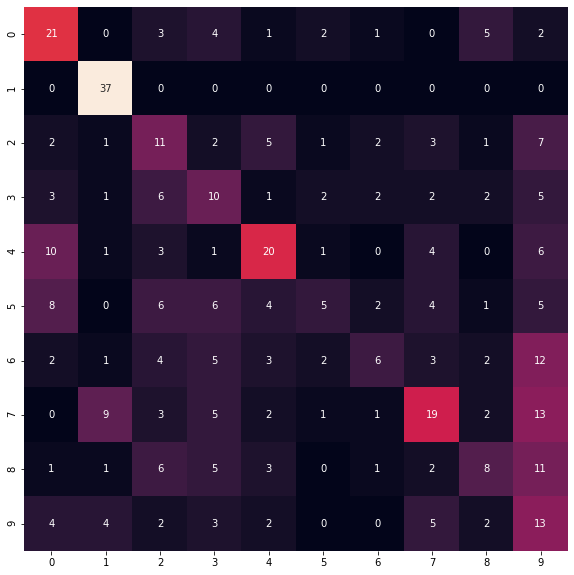


Classification report:
              precision    recall  f1-score   support

           0       0.41      0.54      0.47        39
           1       0.67      1.00      0.80        37
           2       0.25      0.31      0.28        35
           3       0.24      0.29      0.27        34
           4       0.49      0.43      0.46        46
           5       0.36      0.12      0.18        41
           6       0.40      0.15      0.22        40
           7       0.45      0.35      0.39        55
           8       0.35      0.21      0.26        38
           9       0.18      0.37      0.24        35

    accuracy                           0.38       400
   macro avg       0.38      0.38      0.36       400
weighted avg       0.39      0.38      0.36       400



In [ ]:
RFC_classifier(imData4,train_labels)

In [102]:
network = create_model
NN_best_params(imData4, encoded_train_labels, KerasClassifier(network))

Epoch 1/15
59/59 [==============================] - 0s 2ms/step - loss: 1.4922 - accuracy: 0.6765
Epoch 2/15
59/59 [==============================] - 0s 3ms/step - loss: 0.4640 - accuracy: 0.9028
Epoch 3/15
59/59 [==============================] - 0s 2ms/step - loss: 0.2676 - accuracy: 0.9335
Epoch 4/15
59/59 [==============================] - 0s 2ms/step - loss: 0.2085 - accuracy: 0.9441
Epoch 5/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9489
Epoch 6/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1571 - accuracy: 0.9550
Epoch 7/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.9554
Epoch 8/15
59/59 [==============================] - 0s 3ms/step - loss: 0.1274 - accuracy: 0.9602
Epoch 9/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1286 - accuracy: 0.9629
Epoch 10/15
59/59 [==============================] - 0s 2ms/step - loss: 0.1182 - accuracy: 0.9649
Epoch 11/15
59/59 [

Epoch 1/15
59/59 [==============================] - 1s 3ms/step - loss: 125.5397 - accuracy: 0.2842
Epoch 2/15
59/59 [==============================] - 0s 3ms/step - loss: 14.8506 - accuracy: 0.4664
Epoch 3/15
59/59 [==============================] - 0s 3ms/step - loss: 5.0242 - accuracy: 0.5959
Epoch 4/15
59/59 [==============================] - 0s 3ms/step - loss: 2.1509 - accuracy: 0.6913
Epoch 5/15
59/59 [==============================] - 0s 3ms/step - loss: 1.1452 - accuracy: 0.7960
Epoch 6/15
59/59 [==============================] - 0s 3ms/step - loss: 0.8559 - accuracy: 0.8425
Epoch 7/15
59/59 [==============================] - 0s 3ms/step - loss: 0.5998 - accuracy: 0.8857
Epoch 8/15
59/59 [==============================] - 0s 3ms/step - loss: 0.3895 - accuracy: 0.9177
Epoch 9/15
59/59 [==============================] - 0s 3ms/step - loss: 0.4102 - accuracy: 0.9156
Epoch 10/15
59/59 [==============================] - 0s 3ms/step - loss: 0.3698 - accuracy: 0.9295
Epoch 11/15
59/5

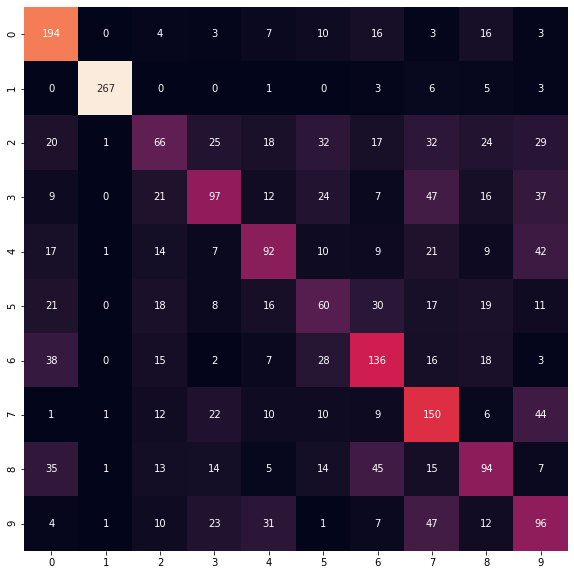

              precision    recall  f1-score   support

           0       0.57      0.76      0.65       256
           1       0.98      0.94      0.96       285
           2       0.38      0.25      0.30       264
           3       0.48      0.36      0.41       270
           4       0.46      0.41      0.44       222
           5       0.32      0.30      0.31       200
           6       0.49      0.52      0.50       263
           7       0.42      0.57      0.48       265
           8       0.43      0.39      0.41       243
           9       0.35      0.41      0.38       232

    accuracy                           0.50      2500
   macro avg       0.49      0.49      0.48      2500
weighted avg       0.50      0.50      0.49      2500



In [103]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(784,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

encoded_train_labels = to_categorical(train_labels)
network.fit(imData4[:7500], encoded_train_labels[:7500], epochs=15, batch_size=128)

test_loss, test_acc = network.evaluate(imData4[7500:10000], encoded_train_labels[7500:10000])
print('test_acc:', test_acc)

pred_probabilities = network.predict(imData4[7500:10000])

pred_labels = np.argmax(pred_probabilities,-1)

cm = confusion_matrix(train_labels[7500:10000], pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()
print(classification_report(train_labels[7500:10000], pred_labels))

# Podsumowanie

### Porównanie wyników działania klasyfikatorów, trenowanymi obrazami oryginalnymi oraz obrazami po zadziałaniu funkcji Deskew:

Z użyciem deskew:
1.   SVM : 0.94
2.   RFC : 0.93
3.   Sieci 0.96

Bez użycia deskew:
1.   SVM : 0.92
2.   RFC : 0.87
3.   Sieci : 0.86

**Wnioski**: Największą różnica przypada dla klasyfikatora Neural Network - funkcja deskew najbardziej pomaga w uczeniu.  W pozostałych przypadkach efekty również są lepsze jeśli użyjemy wspomnianej wcześniej funkcji. 

### Porównanie wyników działania klasyfikatorów, trenowanymi obrazami oryginalnymi oraz danymi po zadziałaniu funkcji OpenCVHOG

Z użyciem HOG:
1.   SVM : 0.94
2.   RFC : 0.93
3.   Sieci 0.96

Bez użycia HOG:
1.   SVM : 0.92
2.   RFC : 0.90
3.   Sieci : 0.91

**Wnioski**: W przypadku wszystkich klasyfikatorów pojawiły się niewielkie różnice. Najlepiej poradził tu sobie SVM dla przypadku bez użycia funkcji HOG.  Sieci natomiast najlepiej poradziły sobie w sytuacji użycia HOG'a. Mimo niedużych różnic można uznać, że HOG wpływa pozytywnie na uczenie.


### Porównanie wyników działania klasyfikatorów, trenowanymi obrazami oryginalnymi oraz danymi "zmieszanymi":

Niezmieszane :
1.   SVM : 0.92
2.   RFC : 0.90
3.   Sieci : 0.94

Zmieszane:
1.   SVM : 0.42
2.   RFC : 0.38
3.   Sieci : 0.50 

**Wnioski**: W ostatnim przypadku różnica jest naprawdę znacząca. Gołym okiem widać, że skuteczność jest dużo mniejsza, aczkolwiek i tak zaskakująco dobra dla danych zmieszanych. Po zmieszaniu najlepiej poradziła sobie sieć, jednak w porównaniu z SVM wyniki są podobne.